In [2]:
# For version check
from platform import python_version
from importlib.metadata import version

In [3]:
import re
import math

import numpy as np
import pandas as pd
import seaborn as sns
import pylab as plt

import networkx as nx
import Bio

In [4]:
print('Python: ', python_version())

print('numpy: ', version('numpy'))
print('pandas: ', pd.__version__)
print('seaborn: ', version('seaborn'))
print('matplotlib: ', version('matplotlib'))

print('networkx: ', nx.__version__)
print('Biopython: ', version('Biopython'))



Python:  3.10.1
numpy:  1.22.3
pandas:  1.4.2
seaborn:  0.11.2
matplotlib:  3.5.2
networkx:  2.8.1
Biopython:  1.79


Python:  3.10.1

numpy:  1.22.3\
pandas:  1.4.2\
seaborn:  0.11.2\
matplotlib:  3.5.2\
networkx:  2.8.1\
Biopython:  1.79

# GenOrigin

The gene ages calculated from the protein ages gave different results for human and mouse and yeast GRNs. We decided to use the gene ages from the GenOrigin database for calculations.


## Contents:
1. [Yeast GRN](#Yeast).\
   1.1. [Load and transfrom numbers to classes](#Yeast_load).\
   1.2. [Heatmap](#Yeast_heatmap).\
   1.3. [Edge "len"](#Yeast_len).


In [5]:
# load GRNs:

# yeast
yeast_data = pd.read_csv('../data/01_GRNs/yeast.txt', sep='\t')
yeast_graph = nx.from_pandas_edgelist(yeast_data, source='Tf', target='Tg', 
                                      create_using=nx.DiGraph())

# mouse
mouse_data = pd.read_csv('../data/01_GRNs/trrust_rawdata.mouse.tsv', 
                         sep='\t', header=None, 
                         names=['TF', 'Target', 'Mode', 'PMID'])
mouse_graph = nx.from_pandas_edgelist(mouse_data, 'TF', 'Target', ['Mode', 'PMID'], 
                                      create_using=nx.DiGraph())

# human
human_data = pd.read_csv('../data/01_GRNs/trrust_rawdata.human.tsv', 
                         sep='\t', header=None, 
                         names=['TF', 'Target', 'Mode', 'PMID'])
human_graph = nx.from_pandas_edgelist(human_data, 'TF', 'Target', ['Mode', 'PMID'], 
                                      create_using=nx.DiGraph())

# 1. Yeast GRN <a name="Yeast"></a>
 
## 1.1. Load and transfrom numbers to classes <a name="Yeast_load"></a>

In [49]:
yeast_gen_ages = pd.read_csv('../data/03_GenOrigin/Saccharomyces_cerevisiae.csv')

#rename for mapping
yeast_gen_ages. rename(columns = {'ensembl_id':'Tf'}, inplace = True)

In [6]:
# tranform numbers to classes using GenOrigin tree

yeast_gen_ages['gene_age'] = yeast_gen_ages['gene_age'].apply(lambda x: 4290 if x == '>4290' else x)
yeast_gen_ages["gene_age"] = pd.to_numeric(yeast_gen_ages["gene_age"])

In [7]:
yeast_gen_ages['distance'] = np.where(yeast_gen_ages['gene_age'] <= 69,
                                      'Saccharomyces',
                                      yeast_gen_ages['gene_age'])

yeast_gen_ages['distance'] = np.where((yeast_gen_ages['gene_age'] <= 212) & (yeast_gen_ages['gene_age'] > 69),
                                      'Saccharomycetaceae',
                                      yeast_gen_ages['distance'])

yeast_gen_ages['distance'] = np.where((yeast_gen_ages['gene_age'] <= 590) & (yeast_gen_ages['gene_age'] > 212),
                                      'Saccharomyceta',
                                      yeast_gen_ages['distance'])

yeast_gen_ages['distance'] = np.where((yeast_gen_ages['gene_age'] <= 723) & (yeast_gen_ages['gene_age'] > 590),
                                      'Ascomycota',
                                      yeast_gen_ages['distance'])

yeast_gen_ages['distance'] = np.where((yeast_gen_ages['gene_age'] <= 817) & (yeast_gen_ages['gene_age'] > 723),
                                      'Dikarya',
                                      yeast_gen_ages['distance'])

yeast_gen_ages['distance'] = np.where((yeast_gen_ages['gene_age'] <= 1105) & (yeast_gen_ages['gene_age'] > 817),
                                      'Fungi',
                                      yeast_gen_ages['distance'])

yeast_gen_ages['distance'] = np.where((yeast_gen_ages['gene_age'] <= 1480) & (yeast_gen_ages['gene_age'] > 1105),
                                      'Opisthokonta',
                                      yeast_gen_ages['distance'])

yeast_gen_ages['distance'] = np.where((yeast_gen_ages['gene_age'] <= 2101) & (yeast_gen_ages['gene_age'] > 1480),
                                      'Eukaryota',
                                      yeast_gen_ages['distance'])

yeast_gen_ages['distance'] = np.where((yeast_gen_ages['gene_age'] <= 4290) & (yeast_gen_ages['gene_age'] > 2101),
                                      '> Eukaryota',
                                      yeast_gen_ages['distance'])

In [8]:
# results

print(yeast_gen_ages.shape)
yeast_gen_ages.head()

(6600, 4)


,Tf,gene_age,gene_Interval,distance
0,YDR301W,34,0-69,Saccharomyces
1,YDR302W,34,0-69,Saccharomyces
2,YDR303C,163,114-212,Saccharomycetaceae
3,YDR304C,1488,1480-1496,Eukaryota
4,YDR305C,1488,1480-1496,Eukaryota


In [12]:
yest_TFTG = set(list(yeast_data.Tf) + list(yeast_data.Tg))
yeast_gene_ages = yeast_gen_ages.query('Tf in @yest_TFTG')
print(yeast_gene_ages.shape)

(4185, 4)


In [13]:
# Class distribution
yeast_sum_ages = yeast_gene_ages.groupby('distance', as_index=0).count()[['distance', 'Tf']]
yeast_sum_ages.loc["Total"] = yeast_sum_ages.sum()
yeast_sum_ages.loc['Total', 'distance'] = 'Total'
yeast_sum_ages.rename(columns = {'distance':'Age class', 'Tf': 'Genes number'}, inplace = True)
yeast_sum_ages

,Age class,Genes number
0,> Eukaryota,332
1,Ascomycota,950
2,Dikarya,213
3,Eukaryota,539
4,Fungi,463
5,Opisthokonta,81
6,Saccharomyces,688
7,Saccharomyceta,445
8,Saccharomycetaceae,474
Total,Total,4185


In [14]:
# mapping
yeast_data['Tf_age'] = yeast_data.merge(yeast_gen_ages, how='left', on=['Tf']).distance

yeast_gen_ages. rename(columns = {'Tf':'Tg'}, inplace = True)
yeast_data['Tg_age'] = yeast_data.merge(yeast_gen_ages, how='left', on=['Tg']).distance

In [15]:
yeast_data.head()

,Tf,Tg,Tf_age,Tg_age
0,YAL051W,YAL016W,Saccharomycetaceae,Fungi
1,YAL051W,YAL034WA,Saccharomycetaceae,NaN
2,YAL051W,YAL035CA,Saccharomycetaceae,NaN
3,YAL051W,YAL035W,Saccharomycetaceae,> Eukaryota
4,YAL051W,YAL036C,Saccharomycetaceae,> Eukaryota


## 1.2. Heatmap <a name="Yeast_heatmap"></a>

In [17]:
# Substituting nans with "no info"
yeast_data[['Tg_age', 'Tf_age']] = yeast_data[['Tg_age', 'Tf_age']].replace(np.nan, 'no info')

In [31]:
heatmap_y = pd.crosstab(yeast_data.Tf_age, yeast_data.Tg_age)
heatmap_y

Tg_age,> Eukaryota,Ascomycota,Dikarya,Eukaryota,Fungi,Opisthokonta,Saccharomyces,Saccharomyceta,Saccharomycetaceae,no info
Tf_age,,,,,,,,,,
> Eukaryota,52,130,20,78,52,9,57,57,48,34
Ascomycota,210,602,134,341,261,36,451,297,368,151
Dikarya,4,8,2,12,11,1,25,12,25,8
Eukaryota,73,187,49,83,83,12,161,99,113,54
Fungi,118,495,87,233,232,28,438,250,278,187
Opisthokonta,56,160,35,83,79,12,115,68,72,28
Saccharomyces,70,217,35,112,88,12,209,92,133,59
Saccharomyceta,163,377,110,234,201,32,334,213,211,106
Saccharomycetaceae,132,497,98,247,196,19,461,268,317,163


Text(0.5, 0.98, 'Age classes heatmap, yeast (GenOrigin)')

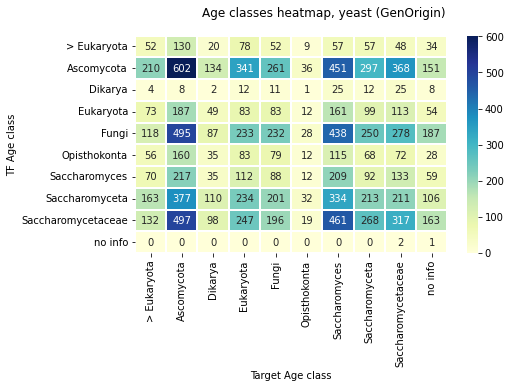

In [42]:
plt.rcParams["figure.figsize"] = 7, 4


x_axis_labels = ['> Eukaryota', 'Ascomycota', 'Dikarya', 'Eukaryota', 'Fungi', 'Opisthokonta', 
                 'Saccharomyces', 'Saccharomyceta','Saccharomycetaceae', 'no info']

y_axis_labels = ['> Eukaryota', 'Ascomycota', 'Dikarya', 'Eukaryota', 'Fungi', 'Opisthokonta', 
                 'Saccharomyces', 'Saccharomyceta','Saccharomycetaceae', 'no info']

s = sns.heatmap(heatmap_y,
                xticklabels=x_axis_labels, 
                yticklabels=y_axis_labels,
                annot=True, 
                fmt='g', 
                cmap="YlGnBu",
                linewidths=1.5)

s.set(xlabel='Target Age class', ylabel='TF Age class')
plt.suptitle('Age classes heatmap, yeast (GenOrigin)')

#plt.savefig('../data/03_plots/yeast_heatmap_01.png')
#plt.close()

#### Tg/TF

In [19]:
ages_list = ['no info', '> Eukaryota', 'Eukaryota', 'Opisthokonta', 'Fungi', 'Dikarya', 'Ascomycota', 
            'Saccharomyceta', 'Saccharomycetaceae', 'Saccharomyces']
tf_tg_count = heatmap_y.copy()

for tf_age in ages_list:
    for tg_age in ages_list:
        new_table = yeast_data[(yeast_data.Tg_age == tg_age) & (yeast_data.Tf_age == tf_age)]
        if new_table[['Tf']].nunique().iloc[0] != 0:
            new_value = new_table[['Tg']].nunique().iloc[0] / new_table[['Tf']].nunique().iloc[0]
        else:
            new_value = 0
        tf_tg_count.loc[tf_age, tg_age] = new_value

In [20]:
tf_tg_count

Tg_age,> Eukaryota,Ascomycota,Dikarya,Eukaryota,Fungi,Opisthokonta,Saccharomyces,Saccharomyceta,Saccharomycetaceae,no info
Tf_age,,,,,,,,,,
> Eukaryota,9.800000,25.000000,5.000000,15.600000,12.500000,4.500000,11.000000,11.400000,9.400000,6.800000
Ascomycota,6.250000,15.576923,3.909091,9.791667,7.076923,2.307692,10.185185,7.760000,8.538462,3.500000
Dikarya,1.333333,4.000000,1.000000,2.400000,2.000000,1.000000,5.500000,2.500000,4.000000,2.666667
Eukaryota,6.900000,14.454545,5.000000,6.909091,8.555556,1.833333,13.200000,7.800000,8.636364,4.300000
Fungi,5.277778,17.190476,4.117647,8.000000,8.842105,2.545455,13.136364,8.428571,9.750000,6.300000
Opisthokonta,10.600000,31.400000,6.800000,15.600000,15.400000,2.750000,21.800000,12.400000,13.800000,7.000000
Saccharomyces,5.083333,14.846154,3.200000,7.285714,6.750000,3.000000,10.000000,5.928571,6.250000,4.000000
Saccharomyceta,6.000000,12.727273,4.500000,7.739130,7.400000,2.000000,9.782609,5.600000,5.440000,3.888889
Saccharomycetaceae,4.727273,11.896552,3.523810,6.357143,5.538462,1.357143,9.965517,7.166667,6.785714,4.107143


In [21]:
tf_ages_count = yeast_data.groupby(['Tf', 'Tf_age'], as_index=0).count().groupby('Tf_age', as_index=0).count()[['Tf_age', 'Tf']]
tg_ages_count = yeast_data.groupby(['Tg', 'Tg_age'], as_index=0).count().groupby('Tg_age', as_index=0).count()[['Tg_age', 'Tg']]

Text(0.5, 1.0, 'TG/TF heatmap, yeast (GenOrigin)')

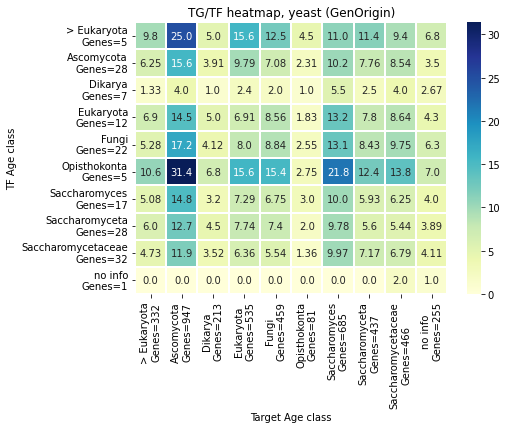

In [40]:
plt.rcParams["figure.figsize"] = 7, 5

xlabels = ['> Eukaryota', 'Ascomycota', 'Dikarya', 'Eukaryota', 'Fungi', 'Opisthokonta', 
           'Saccharomyces', 'Saccharomyceta','Saccharomycetaceae', 'no info']

ylabels = ['> Eukaryota', 'Ascomycota', 'Dikarya', 'Eukaryota', 'Fungi', 'Opisthokonta', 
           'Saccharomyces', 'Saccharomyceta','Saccharomycetaceae', 'no info']
    
x_axis_labels = []
y_axis_labels = []

for label in xlabels:
    x_axis_labels.append(f'{label}\nGenes={tg_ages_count[tg_ages_count.Tg_age == label].Tg.iloc[0]}')

    
for label in ylabels:
    y_axis_labels.append(f'{label}\nGenes={tf_ages_count[tf_ages_count.Tf_age == label].Tf.iloc[0]}')

s = sns.heatmap(tf_tg_count,
                xticklabels=x_axis_labels, 
                yticklabels=y_axis_labels,
                annot=True, 
                fmt=".3",
                cmap="YlGnBu",
                linewidths=1.5)

s.set(xlabel='Target Age class', ylabel='TF Age class')
plt.title('TG/TF heatmap, yeast (GenOrigin)')

#plt.savefig('../data/03_plots/yeast_heatmap_02.png')
#plt.close()

## 1.3. Edge "len"  <a name="Yeast_len"></a>

In [43]:
classes = ['no info', '> Eukaryota', 'Eukaryota', 'Opisthokonta', 'Fungi', 'Dikarya', 'Ascomycota', 
           'Saccharomyceta', 'Saccharomycetaceae', 'Saccharomyces']

yeast_data['Tg_age'] = yeast_data['Tg_age'].apply(lambda x: classes.index(x))
yeast_data['Tf_age'] = yeast_data['Tf_age'].apply(lambda x: classes.index(x))

In [44]:
yeast_data['age_length'] = np.where((yeast_data['Tf_age'] == 0) | (yeast_data['Tg_age'] == 0),
                                     -1,
                                     abs(yeast_data['Tf_age'] - yeast_data['Tg_age']))

# no info to NAN
yeast_data['age_length'] = yeast_data['age_length'].replace({-1: np.nan})

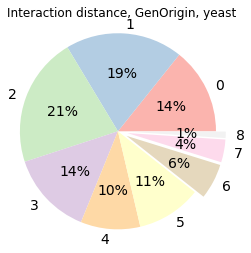

In [48]:
plt.rcParams["figure.figsize"] = 4, 4

idx = [0, 1, 2, 3, 4, 5, 6, 7, 8]
counts = pd.Series(yeast_data['age_length'].value_counts(normalize=True) * 100)
counts.index = counts.index.astype('int64')
counts = counts[idx]

explode = (0, 0, 0, 0, 0, 0, 0.1, 0.1, 0.1)
counts.plot(kind='pie', 
            fontsize=14, 
            colormap="Pastel1", 
            explode=explode,  
            autopct='%.0f%%')
plt.axis('equal')
plt.ylabel('')
plt.title('Interaction distance, GenOrigin, yeast')

plt.show()
#plt.savefig('../data/03_plots/yeast_len.png')
#plt.close()